# <center><b>Problem Statment</b></center>

A retail bank has conducted a series of direct marketing campaigns via phone calls to promote term deposit subscriptions. The bank wants to use machine learning to predict whether a customer will subscribe to a term deposit based on demographic, financial, and campaign-related attributes.

# Objective

To develop a classification model that accurately predicts the likelihood of a customer  subscribing to a term deposit using historical campaign data. This can help the bank


* Improve targeting for future campaigns.
* Reduce marketing costs.
* Increase campaign success rates.tes.



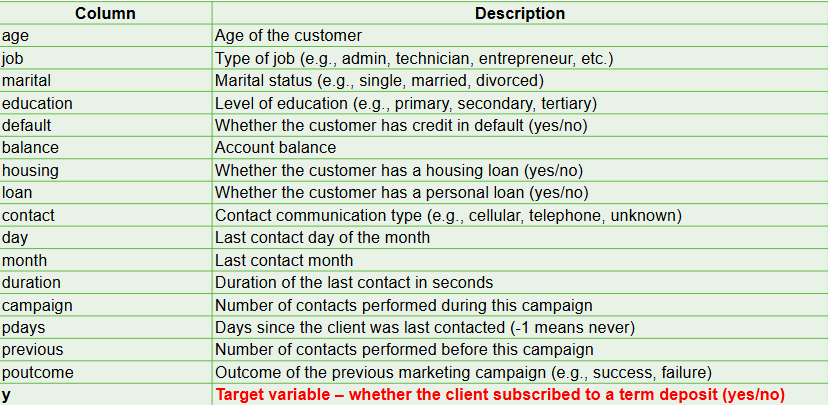

In [2]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

#import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        # from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

#ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import data
df = pd.read_excel('Banking_Call_Data.xlsx')

#data dimensions
df.shape

(45211, 17)

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [5]:
#data sample 
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data cleaning

In [7]:
#check duplicates
print('Data has ',df.duplicated().sum(),' duplicate data')

Data has  0  duplicate data


In [8]:
#check null values
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
for col in df.select_dtypes(include='O').columns:
    print('-------------------------------',col,'---------------------------------')
    print(df[col].value_counts())
    print()

------------------------------- job ---------------------------------
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

------------------------------- marital ---------------------------------
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

------------------------------- education ---------------------------------
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

------------------------------- default ---------------------------------
default
no     44396
yes      815
Name: count, dtype: int64

------------------------------- housing ---------------------------------
housing
yes    25130
no     20081
Name: count, dtype: int64

-------------

### Observation:
1. There is no missing data in numerical features.
2. In categorical features <b> job, education , contact, poutcome </b> this columns have unknown value which we can consider as null values.

In [11]:
for col in df[['job', 'education', 'contact', 'poutcome']]:
    print('-------------------------------',col,'---------------------------------')
    print(df[col].value_counts(normalize=True)*100)
    print()

------------------------------- job ---------------------------------
job
blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: proportion, dtype: float64

------------------------------- education ---------------------------------
education
secondary    51.319369
tertiary     29.419831
primary      15.153392
unknown       4.107407
Name: proportion, dtype: float64

------------------------------- contact ---------------------------------
contact
cellular     64.774059
unknown      28.798301
telephone     6.427639
Name: proportion, dtype: float64

------------------------------- poutcome ---------------------------------
poutcome
unknown    81.747805
failure    10.840282
other       4.069806
success     3.342107
Nam

### Observation: 
Total unknown values per catecory
1. job: 0.637013
2. education:  4.107407
3. contact: 28.798301
4. poutcome: 81.747805
######
1. <b>poutcome</b> has <b>81%</b> missing values which is very much high and we can not use mode to fill the missing value as it will become bias toward mode value and this feature will not provide any insight about future prediction, so it is better to <b>drop this column</b>.
2. <b>contact</b> has <b>28%</b> missing value, here we can use <b>mode to fill</b> those unknown values.
3. For <b> job and education </b> also use <b>mode to fill</b> unknown.

In [13]:
del df['poutcome']
df['job'] = np.where(df['job']=='unknown',df['job'].mode()[0],df['job'])
df['education'] = np.where(df['education']=='unknown',df['education'].mode()[0],df['education'])
df['contact'] = np.where(df['contact']=='unknown',df['contact'].mode()[0],df['contact'])

In [14]:
# after unknown treatment
for col in df[['job', 'education', 'contact']]:
    print('-------------------------------',col,'---------------------------------')
    print(df[col].value_counts(normalize=True)*100)
    print()

------------------------------- job ---------------------------------
job
blue-collar      22.162748
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
Name: proportion, dtype: float64

------------------------------- education ---------------------------------
education
secondary    55.426777
tertiary     29.419831
primary      15.153392
Name: proportion, dtype: float64

------------------------------- contact ---------------------------------
contact
cellular     93.572361
telephone     6.427639
Name: proportion, dtype: float64



In [15]:
#check data types
pd.concat([df.dtypes,df.head().T],axis=1)

,0,0,1,2,3,4
age,int64,58,44,33,47,33
job,object,management,technician,entrepreneur,blue-collar,blue-collar
marital,object,married,single,married,married,single
education,object,tertiary,secondary,secondary,secondary,secondary
default,object,no,no,no,no,no
balance,int64,2143,29,2,1506,1
housing,object,yes,yes,yes,yes,no
loan,object,no,no,yes,no,no
contact,object,cellular,cellular,cellular,cellular,cellular
day,int64,5,5,5,5,5


### Observation:
DataTypes are correct 

## EDA (Exploratory Data Analysis)

### Observation:
1. pdays has -1 and previous has 0 as never contacted.
2. pdays and previous are combination of categorical and numerical.
3. Split pdays and previous to categorical and numerical
4. previous has one data point which is far from all other outliers so remove it 

In [19]:
df['never_contacted'] = df['pdays'].apply(lambda x:0 if x==-1 else 1)
df['pdays'] = df['pdays'].apply(lambda x:0 if x==-1 else x)
df['previous'] = np.where(df['previous']==275,58,df['previous'])

In [20]:
#numerical feature analysis
num_df = df.select_dtypes(exclude='O')

num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,41.015195,99.792615,0.0,0.0,0.0,0.0,871.0
previous,45211.0,0.575524,1.926927,0.0,0.0,0.0,0.0,58.0
never_contacted,45211.0,0.182633,0.386369,0.0,0.0,0.0,0.0,1.0


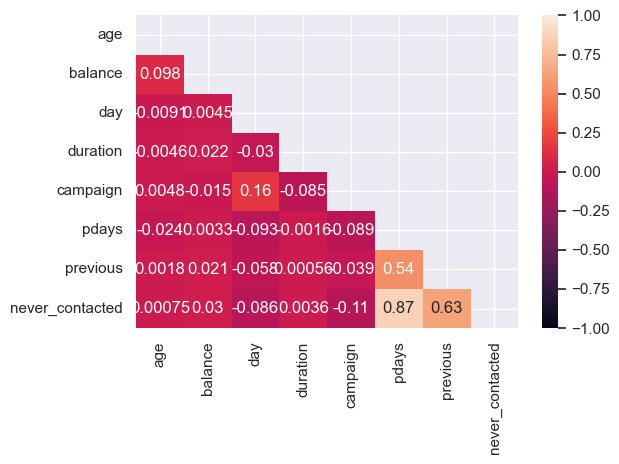

In [21]:
# plt.figure(figsize=(13,8))
sns.heatmap(df.corr(numeric_only=True),vmin=-1,vmax=1,annot=True,mask=np.triu(df.corr(numeric_only=True)))
plt.tight_layout()
plt.show()

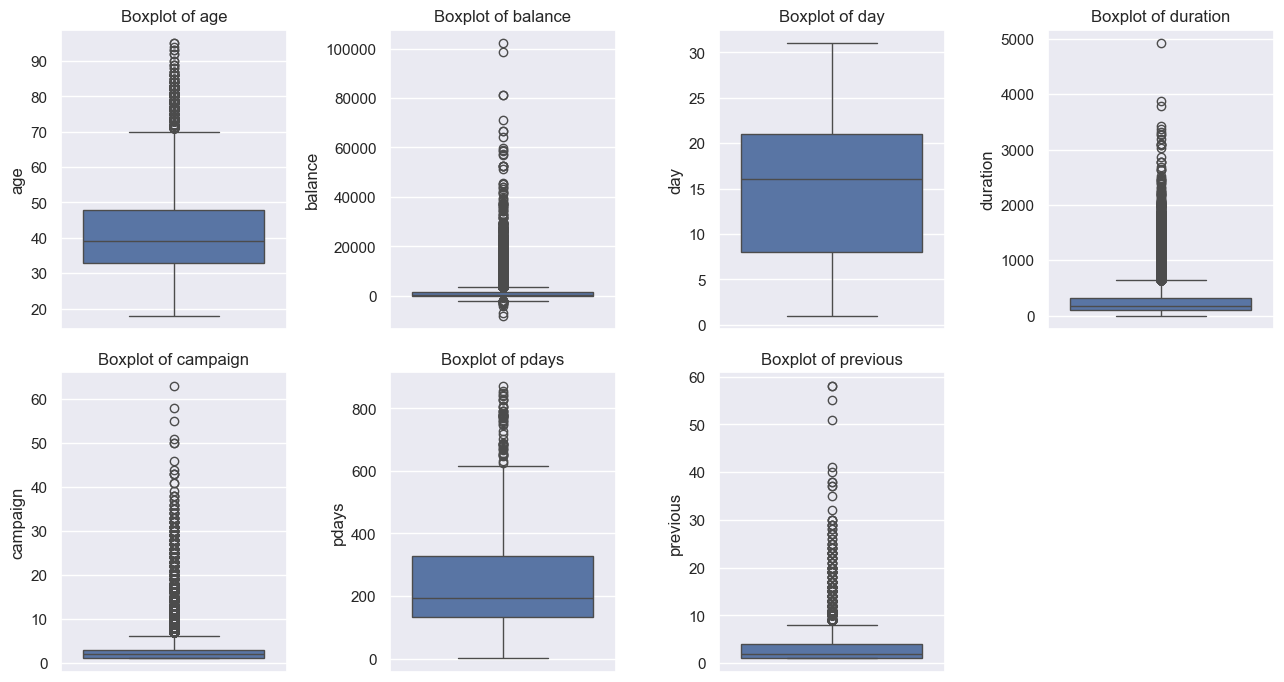

In [22]:
fig, axes = plt.subplots(2,4,figsize=(13,7))
axes = axes.flatten()

for i, col in enumerate(num_df.columns):
    if col == 'pdays' or  col == 'previous':
         sns.boxplot(y=col, data=num_df[num_df[col]>0], ax=axes[i])
    else:
        sns.boxplot(y=col, data=num_df, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    
fig.delaxes(axes[7]) #remove unused plot
plt.tight_layout()
plt.show()


### Observation:
1. Except of day column all other features have significant outliers.

In [24]:
num_df.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'never_contacted'],
      dtype='object')

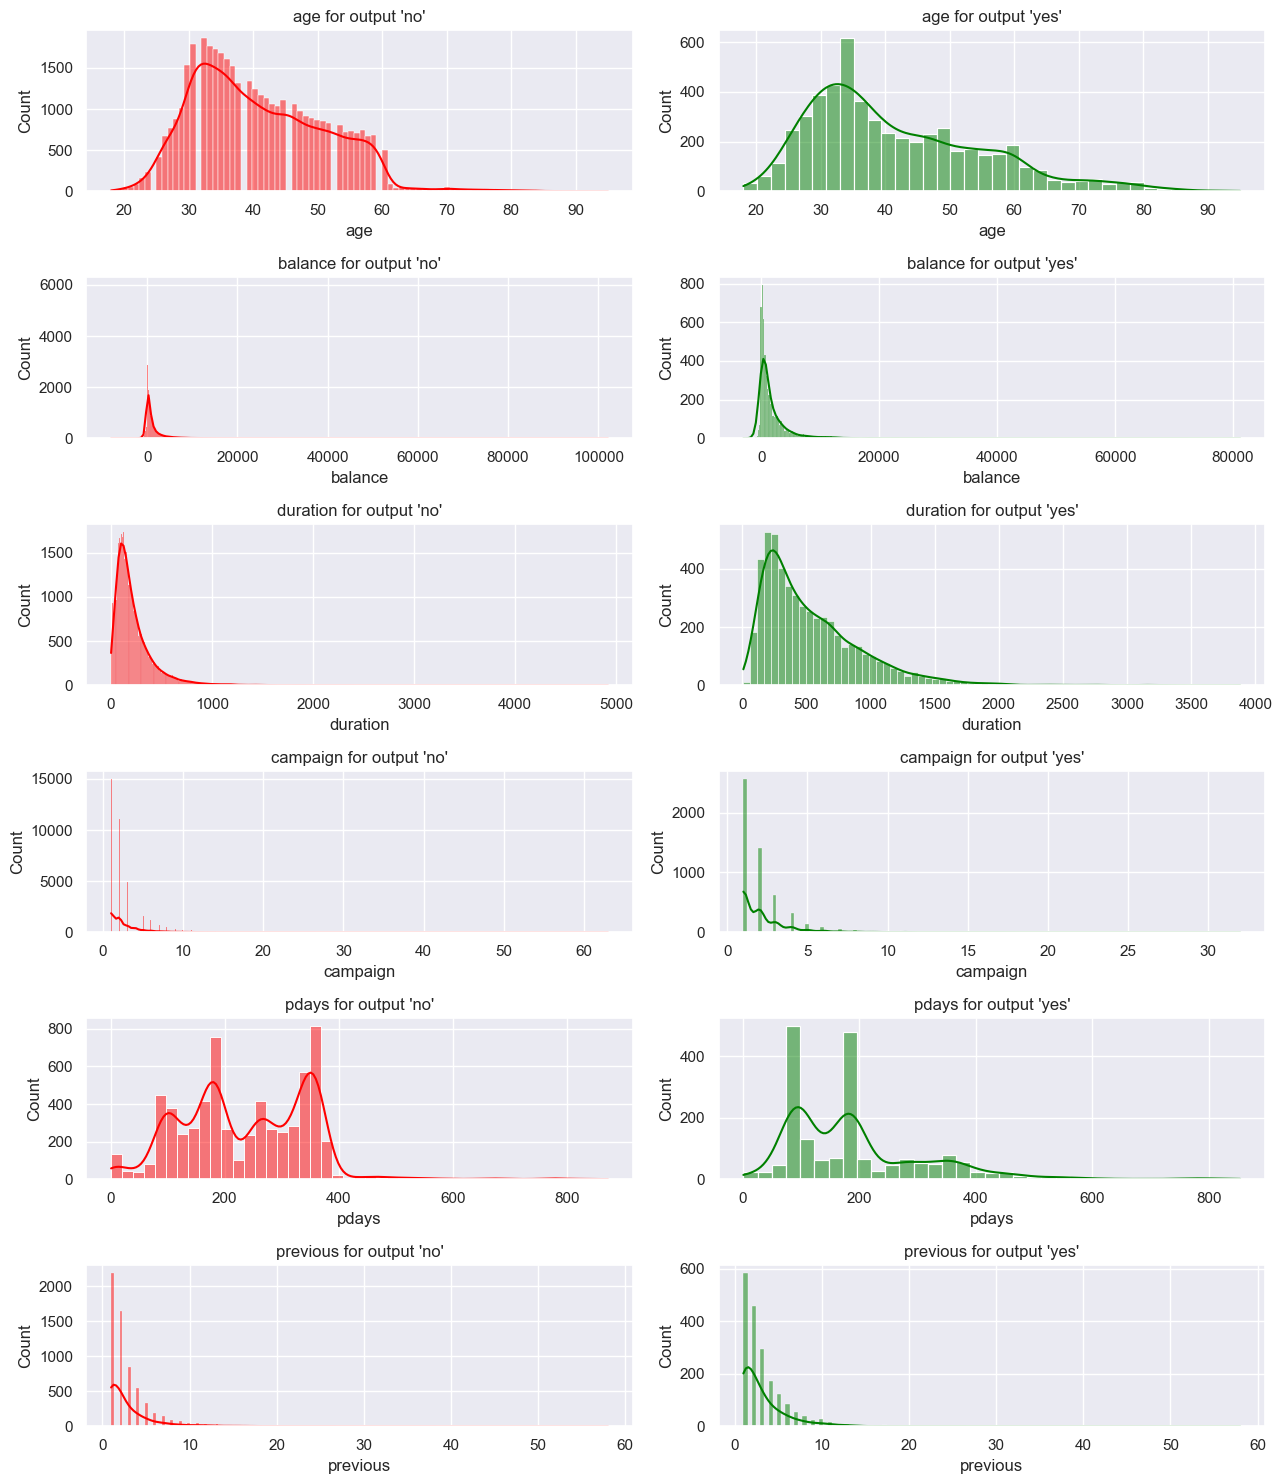

In [25]:
fig, axes = plt.subplots(6,2,figsize=(13,15))
axes = axes.flatten()
i=0
for col in df[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].columns:
    if col == 'pdays' or col == 'previous':
        sns.histplot(x=col, data=df[(df['y']=='no') & (df[col]>0)], ax=axes[i], fill=True, kde=True, color='red')
        axes[i].set_title(f"{col} for output 'no'")
        i+=1
        sns.histplot(x=col, data=df[(df['y']=='yes') & (df[col]>0)], ax=axes[i], fill=True, kde=True, color='green')
        axes[i].set_title(f"{col} for output 'yes'")
        i+=1
    else:
        sns.histplot(x=col, data=df[df['y']=='no'], ax=axes[i], fill=True, kde=True, color='red')
        axes[i].set_title(f"{col} for output 'no'")
        i+=1
        sns.histplot(x=col, data=df[df['y']=='yes'], ax=axes[i], fill=True, kde=True, color='green')
        axes[i].set_title(f"{col} for output 'yes'")
        i+=1
    
# fig.delaxes(axes[7]) #remove unused plot
plt.tight_layout()
plt.show()

### Note: Can not use IQR method because,
When you clip many outliers, a lot of data points get squashed into the upper/lower bounds, and you may see:
1. High frequency at the max/min value
2. Distorted distribution
3. Loss of variability, which can hurt model performance

Even after using all other outliar treatments it still not getting rid of outliars, so it is better to use Tree based model bacause it handles the outliars better.

In [30]:
#understand categorical columns
categorical_fields = df.drop(columns=['y'],axis=1).select_dtypes(include='O')

for col in categorical_fields.columns:
    print(col,': ',categorical_fields[col].unique())

job :  ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
marital :  ['married' 'single' 'divorced']
education :  ['tertiary' 'secondary' 'primary']
default :  ['no' 'yes']
housing :  ['yes' 'no']
loan :  ['no' 'yes']
contact :  ['cellular' 'telephone']
month :  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


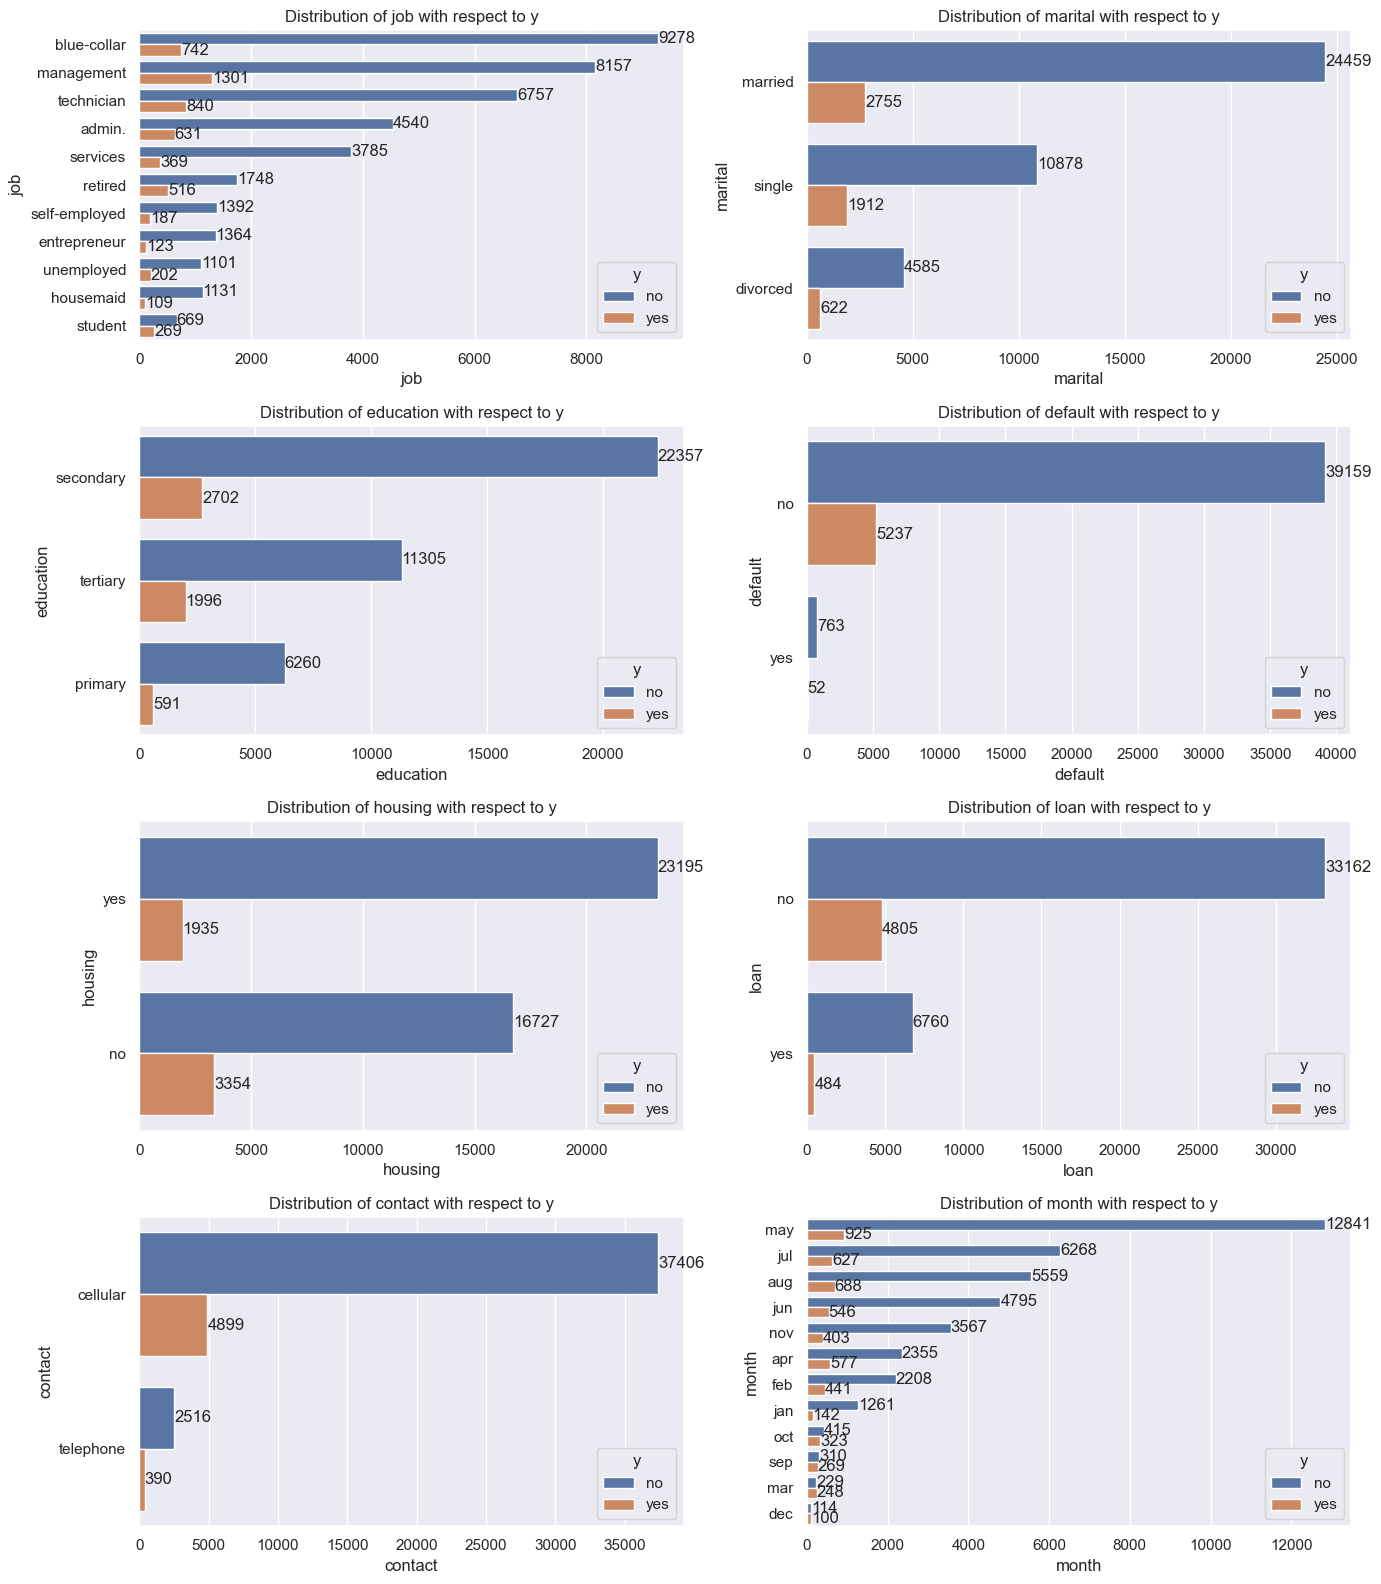

In [31]:
#plot caregorical_fields
plt.figure(figsize=(14, 16)) 
i =1
for col in categorical_fields.columns:
    plt.subplot(4, 2, i)  
    ax = sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='deep', hue='y')  
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f'Distribution of {col} with respect to y')
    plt.xlabel(col)
    # plt.xticks(rotation=45)
    i += 1
plt.tight_layout()
# plt.savefig('CategoricalFeatures.png')
plt.show()

In [32]:
#target variable analysis
round(df['y'].value_counts(normalize=True)*100,2)


y
no     88.3
yes    11.7
Name: proportion, dtype: float64

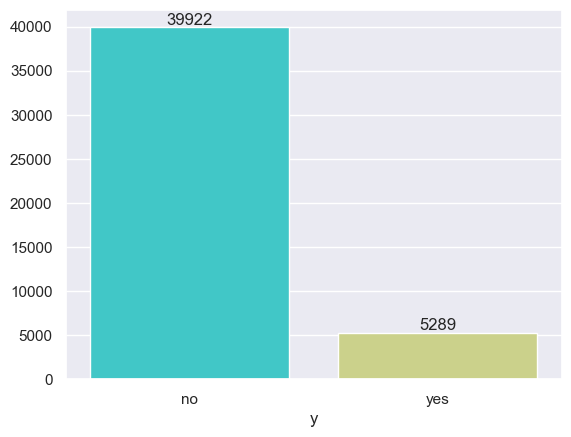

In [33]:
#plot target column
# plt.figure(figsize=(13,5))
ax = sns.barplot(x=df['y'].value_counts().index,y=df['y'].value_counts().values,palette='rainbow')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
# plt.savefig('TargetColumn.png')
plt.show()

#### Observation : 
1. Target column is categorical data
2. It is binary classification problem
3. Data are imbalanced with 88-11%

In [35]:
#categorical features
for col in df.select_dtypes(include='O').columns:
    print('-----------------',col,'-----------------')
    print(col,': ',df[col].unique())

----------------- job -----------------
job :  ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
----------------- marital -----------------
marital :  ['married' 'single' 'divorced']
----------------- education -----------------
education :  ['tertiary' 'secondary' 'primary']
----------------- default -----------------
default :  ['no' 'yes']
----------------- housing -----------------
housing :  ['yes' 'no']
----------------- loan -----------------
loan :  ['no' 'yes']
----------------- contact -----------------
contact :  ['cellular' 'telephone']
----------------- month -----------------
month :  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
----------------- y -----------------
y :  ['no' 'yes']


### Observation:
1. job, education and month are ordinal data
2. other chategorical features are nominal

In [37]:
#encoding of ordinal categorical features
job_mapping = {
    "management": 0,
    "entrepreneur": 1,
    "self-employed": 2,
    "technician": 3,
    "blue-collar": 4,
    "services": 5,
    "admin.": 6,
    "housemaid": 7,
    "student": 8,
    "unemployed": 9,
    "retired": 10
}

education_mapping = {
    "primary": 0,
    "secondary": 1,
    "tertiary": 2
}


month_mapping = {
    "jan": 0,
    "feb": 1,
    "mar": 2,
    "apr": 3,
    "may": 4,
    "jun": 5,
    "jul": 6,
    "aug": 7,
    "sep": 8,
    "oct": 9,
    "nov": 10,
    "dec": 11
}

df['job'] = df['job'].str.strip().str.lower()
df['education'] = df['education'].str.strip().str.lower()
df['month'] = df['month'].str.strip().str.lower()

df['job'] = df['job'].map(job_mapping)
df['education'] = df['education'].map(education_mapping)
df['month'] = df['month'].map(month_mapping)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,never_contacted
0,58,0,married,2,no,2143,yes,no,cellular,5,4,261,1,0,0,no,0
1,44,3,single,1,no,29,yes,no,cellular,5,4,151,1,0,0,no,0
2,33,1,married,1,no,2,yes,yes,cellular,5,4,76,1,0,0,no,0
3,47,4,married,1,no,1506,yes,no,cellular,5,4,92,1,0,0,no,0
4,33,4,single,1,no,1,no,no,cellular,5,4,198,1,0,0,no,0


In [38]:
#encoding of nominal categorical features

df_encoded = pd.get_dummies(df.select_dtypes(include='O'),dtype='int',drop_first=True, )

#sample data after encoding
df_encoded.head()

,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,y_yes
0,1,0,0,1,0,0,0
1,0,1,0,1,0,0,0
2,1,0,0,1,1,0,0
3,1,0,0,1,0,0,0
4,0,1,0,0,0,0,0


In [39]:
#concat categorical field with numerical field
df_new = pd.concat([
    df.drop(columns=df.select_dtypes(include='O').columns),  # remove object columns
    df_encoded  # add encoded dummy variables
], axis=1)
df_new.head()


,age,job,education,balance,day,month,duration,campaign,pdays,previous,never_contacted,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,y_yes
0,58,0,2,2143,5,4,261,1,0,0,0,1,0,0,1,0,0,0
1,44,3,1,29,5,4,151,1,0,0,0,0,1,0,1,0,0,0
2,33,1,1,2,5,4,76,1,0,0,0,1,0,0,1,1,0,0
3,47,4,1,1506,5,4,92,1,0,0,0,1,0,0,1,0,0,0
4,33,4,1,1,5,4,198,1,0,0,0,0,1,0,0,0,0,0


In [40]:
#train test split
x = df_new.drop(columns=['never_contacted','y_yes'], axis=1)
y = df_new['y_yes']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify=y)

#data dimension of train and test
print('x_train: ',x_train.shape)
print('y_train: ',y_train.shape)
print('x_test: ',x_test.shape)
print('y_test: ',y_test.shape)

x_train:  (36168, 16)
y_train:  (36168,)
x_test:  (9043, 16)
y_test:  (9043,)


This data contains outliers, it's important to choose models that are robust to outliers, meaning they won't be heavily influenced by extreme values.

Best model for data with outliers are 
Decision Tree, 
Random Forest, 
Gradient Boosting (like XGBoost, LightGBM) — split data based on thresholds, so outliers have less impact.

## Model building

In [43]:
# Base models
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
gb = GradientBoostingClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
cb = CatBoostClassifier(silent=True, random_state=42, )
bc = BaggingClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


# Voting Classifier (can be hard or soft)
voting_hard = VotingClassifier(
    estimators=[
        ('DT', dt),
        ('RF', rf),
        ('GB', gb),
        ('ET', et),
        ('CB', cb),
        ('BC', bc),
        ('LGB', lgb),
        ('XGB', xgb)
    ],
    voting='hard'
)


models = {
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Extra Trees': et,
    'CatBoost': cb,
    'Bagging': bc,
    'LightGBM': lgb,
    'XGBoost': xgb,
    'Voting (hard)': voting_hard
}


In [44]:
model_names = []
model_train_acc = []
model_test_acc = []
precision_acc = []
recall_acc = []
f1_acc = []
result_df = {}

for name, model in models.items():
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    y_pred = model.predict(x_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_names.append(name)
    model_train_acc.append(train_score)
    model_test_acc.append(acc)
    precision_acc.append(precision)
    recall_acc.append(recall)
    f1_acc.append(f1)

result_df = {
    'Model_name' : model_names,
    'Train_acc' : model_train_acc,
    'Test_acc' : model_test_acc,
    'Precision_acc' : precision_acc,
    'Recall_acc' : recall_acc,
    'f1_score' : f1_acc
}
result_df = pd.DataFrame(result_df)


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [bin

In [45]:
result_df

,Model_name,Train_acc,Test_acc,Precision_acc,Recall_acc,f1_score
0,Decision Tree,1.000000,0.867743,0.435874,0.443289,0.439550
1,Random Forest,1.000000,0.896937,0.614964,0.318526,0.419676
2,Gradient Boosting,0.905994,0.898043,0.615646,0.342155,0.439854
3,Extra Trees,1.000000,0.896052,0.610075,0.309074,0.410289
4,CatBoost,0.941440,0.903682,0.622543,0.448960,0.521691
5,Bagging,0.992590,0.894504,0.577844,0.364839,0.447277
6,LightGBM,0.929496,0.903240,0.618370,0.451796,0.522119
7,XGBoost,0.954960,0.900144,0.597240,0.449905,0.513208
8,Voting (hard),0.969725,0.900586,0.639719,0.344045,0.447449


### Plot Comparison

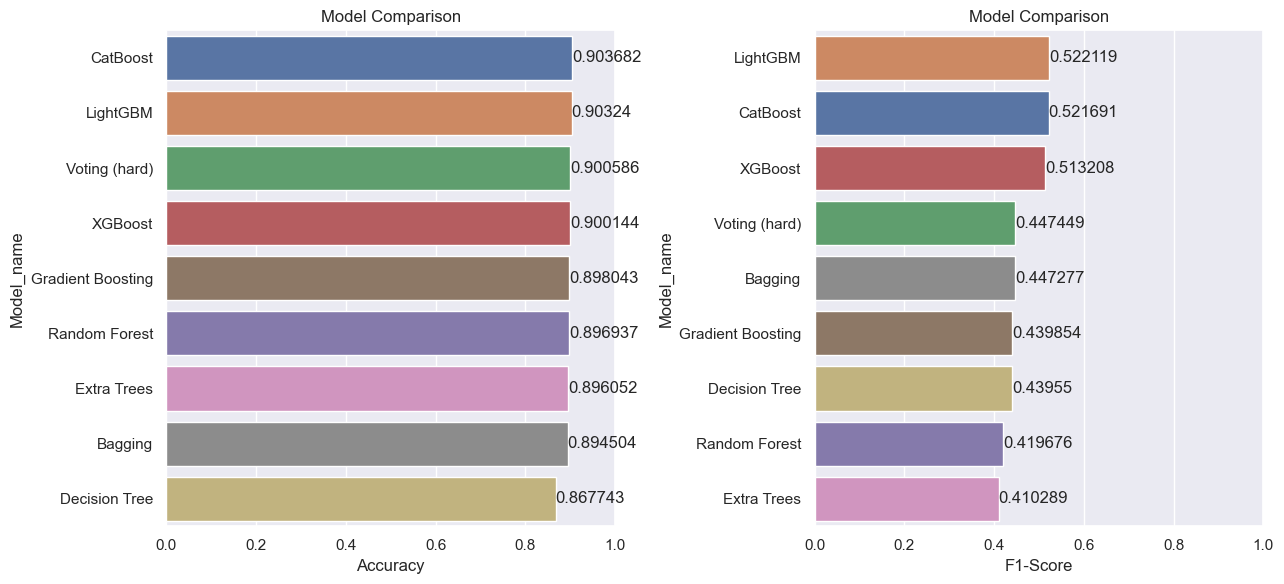

In [47]:

plt.figure(figsize=(13, 6))
custom_palette = {
    "CatBoost": "#4c72b0",          # deep blue
    "LightGBM": "#dd8452",          # orange
    "Voting (hard)": "#55a868",     # green
    "XGBoost": "#c44e52",           # red
    "Random Forest": "#8172b3",     # purple
    "Gradient Boosting": "#937860", # brown
    "Extra Trees": "#da8bc3",       # pink
    "Bagging": "#8c8c8c",           # grey
    "Decision Tree": "#ccb974",     # khaki
}


plt.subplot(1,2,1)
ax = sns.barplot(x='Test_acc', y='Model_name',data=result_df.sort_values(by='Test_acc', ascending=False), palette=custom_palette)
for i in ax.containers:
    plt.bar_label(i)
plt.xlabel("Accuracy")
plt.title("Model Comparison")
plt.xlim(0, 1)

plt.subplot(1,2,2)
ax = sns.barplot(x='f1_score', y='Model_name',data=result_df.sort_values(by='f1_score', ascending=False), palette=custom_palette)
for i in ax.containers:
    plt.bar_label(i)
plt.xlabel("F1-Score")
plt.title("Model Comparison")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()


### Observation:
1. Decision Tree, Random Forest, Extra Trees, Bagging => this models overfit the data.
2. All models giving poor f1-score
3. Out of all CatBoost, LightGBM and XGBoost giving better acuuracy and f1-score

### Note:
1. Hyperparameter not giving any significat better accuracy
2. I will use LightGBM as my main model 

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7985
           1       0.43      0.88      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.71      0.86      0.74      9043
weighted avg       0.92      0.85      0.87      9043

Train Accuracy: 0.8572218535722186
Test Accuracy: 0.8497180139334292
precision: 0.43054914628518687
recall: 0.8818525

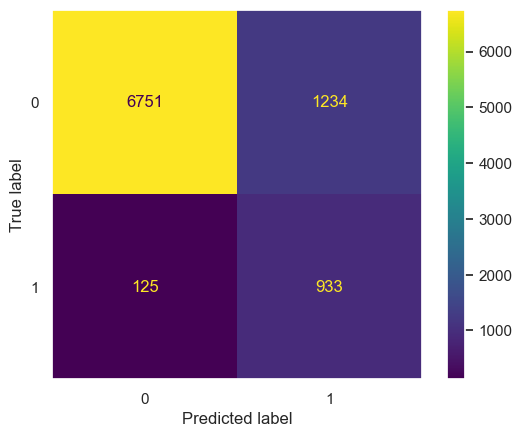

In [50]:
#LightGBM

pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_weight = neg / pos

lgb = LGBMClassifier(random_state=42,learning_rate=0.06, scale_pos_weight=scale_weight)
lgb.fit(x_train, y_train)
y_pred = lgb.predict(x_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(classification_report(y_test, y_pred))
print('Train Accuracy:',lgb.score(x_train, y_train))
print('Test Accuracy:',accuracy_score(y_test, y_pred))
print('precision:',precision)
print('recall:',recall)
print('f1:',f1)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.grid(False)

In [2]:
recall = 933/(125+933)
recall
reces

0.8818525519848771

### Observation:
RECALL is more important in this business problem.
You want to catch as many real subscribers as possible, even if it means sometimes contacting people who won’t convert.


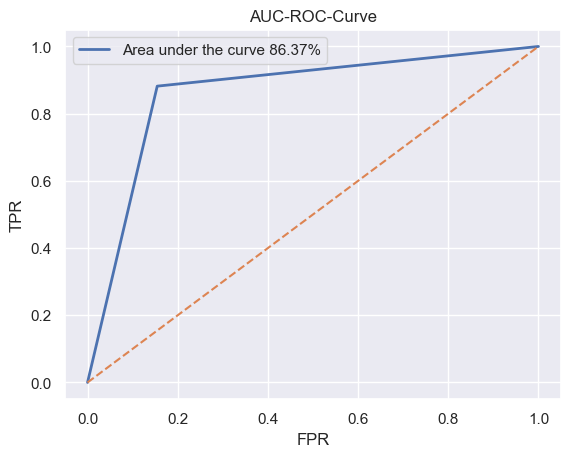

In [52]:
#auc -roc curve
fpr, tpr, thre = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

#plot
plt.plot(fpr, tpr, lw=2, label=f"Area under the curve {round(auc*100,2)}%")
plt.plot([0,1],[0,1],ls='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC-ROC-Curve')
plt.legend()
plt.show()

In [53]:
imp = lgb.feature_importances_
col_names = x_train.columns

fet_imp = pd.DataFrame({'feature':col_names,'importance':imp})
fet_imp = fet_imp.sort_values(by='importance',ascending=False)
fet_imp['importance(%)'] = 100* fet_imp['importance']/fet_imp['importance'].sum()
fet_imp['cummulative(%)'] = fet_imp['importance(%)'].cumsum()
fet_imp

,feature,importance,importance(%),cummulative(%)
5,month,635,21.166667,21.166667
4,day,515,17.166667,38.333333
6,duration,479,15.966667,54.300000
8,pdays,311,10.366667,64.666667
0,age,292,9.733333,74.400000
3,balance,262,8.733333,83.133333
7,campaign,100,3.333333,86.466667
13,housing_yes,86,2.866667,89.333333
2,education,82,2.733333,92.066667
1,job,70,2.333333,94.400000


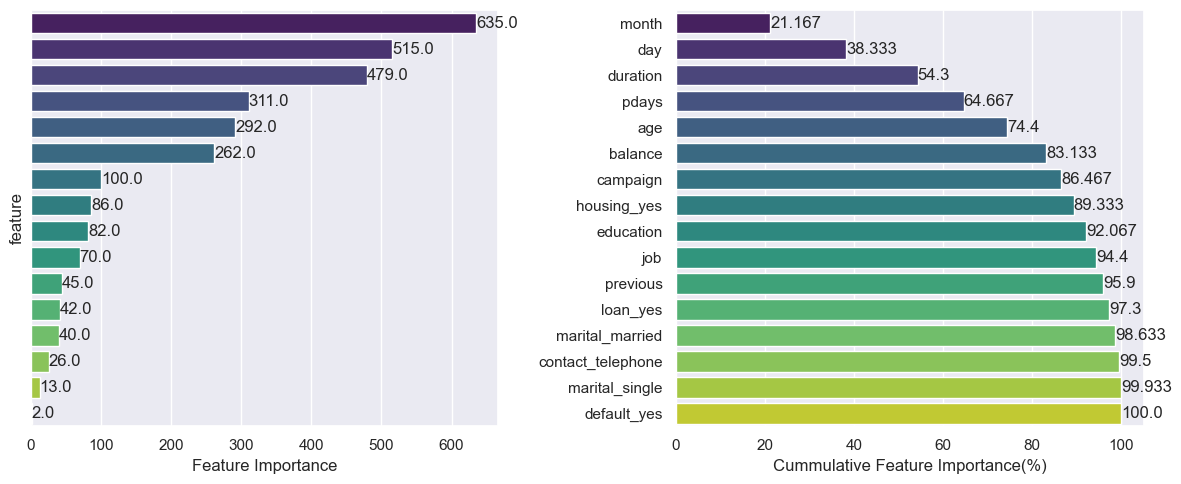

In [54]:
# Plotting Feature Importance
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
ax1=sns.barplot(x='importance', y='feature', data=fet_imp, palette='viridis')
for i in ax1.containers:
    plt.bar_label(i,fmt=lambda x: f'{round(x,3)}')
plt.yticks([])
plt.xlabel('Feature Importance')


plt.subplot(1,2,2)
ax2=sns.barplot(x='cummulative(%)', y='feature', data=fet_imp, palette='viridis')
for i in ax2.containers:
    plt.bar_label(i,fmt=lambda x: f'{round(x,3)}')
plt.ylabel('')
plt.xlabel('Cummulative Feature Importance(%)')

plt.tight_layout()
plt.show()